# dataset loading

In [1]:
import os
import pandas as pd

# Define the folder where your datasets are stored
folder_path = 'churn_data'

# Define the maximum number of rows to keep
max_rows = 50000

# Initialize a dictionary to store the datasets
datasets = {}

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Create the full path to the file
        file_path = os.path.join(folder_path, filename)
        
        # Load the CSV file into a DataFrame
        dataset_name = filename.split('.')[0]  # Use the filename as the dataset name (without .csv)
        df = pd.read_csv(file_path)
        
        # Truncate dataset if larger than max_rows
        if len(df) > max_rows:
            df = df.sample(max_rows, random_state=42)  # Randomly sample rows
        
        datasets[dataset_name] = df
        
        # Print or log the loaded dataset name
        print(f'Loaded dataset: {dataset_name} (rows: {len(df)})')

# At this stage, you have all datasets loaded in the `datasets` dictionary, truncated if necessary


Loaded dataset: BankChurners (rows: 10127)
Loaded dataset: Bank_churn (rows: 10000)
Loaded dataset: churn-bigml-80 (rows: 2666)
Loaded dataset: Customertravel (rows: 954)
Loaded dataset: E Commerce Dataset (rows: 5630)
Loaded dataset: ecom-user-churn-data (rows: 49358)
Loaded dataset: internet_service_churn (rows: 50000)
Loaded dataset: orange_telecom (rows: 667)
Loaded dataset: subscription_service_train (rows: 50000)
Loaded dataset: Telco-Customer-Churn (rows: 7043)
Loaded dataset: telecom_churn (rows: 3333)


# preprocessing

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

def preprocess_dataset(df, target_col='churn'):
    # Step 1: Handle missing values
    # Separate features and target
    X = df.drop(columns=[target_col], errors='ignore')
    y = df[target_col] if target_col in df.columns else None

    # Step 2: Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns

    # Step 3: Create preprocessing pipelines for numeric and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numeric values with mean
        ('scaler', StandardScaler())  # Standardize numeric features
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values with mode
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
    ])

    # Step 4: Apply column transformer to both numeric and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )

    # Step 5: Fit the preprocessor and transform the data
    X_preprocessed = preprocessor.fit_transform(X)

    return X_preprocessed, y

# Example usage:
# Preprocess all datasets
preprocessed_datasets = {}
for dataset_name, df in datasets.items():
    X_preprocessed, y = preprocess_dataset(df)
    preprocessed_datasets[dataset_name] = (X_preprocessed, y)
    print(f'Preprocessed dataset: {dataset_name}')


Preprocessed dataset: BankChurners
Preprocessed dataset: Bank_churn
Preprocessed dataset: churn-bigml-80
Preprocessed dataset: Customertravel
Preprocessed dataset: E Commerce Dataset
Preprocessed dataset: ecom-user-churn-data
Preprocessed dataset: internet_service_churn
Preprocessed dataset: orange_telecom
Preprocessed dataset: subscription_service_train
Preprocessed dataset: Telco-Customer-Churn
Preprocessed dataset: telecom_churn


# model bulding

In [3]:
import os
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Directory to save the models
model_folder = 'models'

# Ensure the model folder exists
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

def train_and_save_model(X, y, dataset_name):
    # Step 1: Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Step 2: Initialize the Random Forest model
    model = RandomForestClassifier(n_estimators=20, random_state=42)
    
    # Step 3: Train the model on the training data
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC-ROC
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    
    # Print evaluation metrics
    print(f"Dataset: {dataset_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Step 5: Save the model with the naming convention "dataset_name_model.pkl"
    model_path = os.path.join(model_folder, f'{dataset_name}_model.pkl')
    joblib.dump(model, model_path)
    print(f"Model saved for dataset: {dataset_name} at {model_path}")

# Iterate over all datasets and train models
for dataset_name, (X_preprocessed, y) in preprocessed_datasets.items():
    train_and_save_model(X_preprocessed, y, dataset_name)


Dataset: BankChurners
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
AUC-ROC: 1.0000
Model saved for dataset: BankChurners at models\BankChurners_model.pkl
Dataset: Bank_churn
Accuracy: 0.8585
Precision: 0.8526
Recall: 0.3384
AUC-ROC: 0.8258
Model saved for dataset: Bank_churn at models\Bank_churn_model.pkl
Dataset: churn-bigml-80
Accuracy: 0.9251
Precision: 0.9535
Recall: 0.5190
AUC-ROC: 0.8995
Model saved for dataset: churn-bigml-80 at models\churn-bigml-80_model.pkl
Dataset: Customertravel
Accuracy: 0.8639
Precision: 0.7000
Recall: 0.5526
AUC-ROC: 0.9234
Model saved for dataset: Customertravel at models\Customertravel_model.pkl
Dataset: E Commerce Dataset
Accuracy: 0.9591
Precision: 0.9860
Recall: 0.7622
AUC-ROC: 0.9794
Model saved for dataset: E Commerce Dataset at models\E Commerce Dataset_model.pkl
Dataset: ecom-user-churn-data
Accuracy: 0.8899
Precision: 0.9004
Recall: 0.9854
AUC-ROC: 0.6986
Model saved for dataset: ecom-user-churn-data at models\ecom-user-churn-data_model.pk

# For a samle dataset - EDA

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the folder where your datasets are stored
folder_path = 'churn_data'

# Function to load a sample dataset
def load_sample_dataset(folder_path, sample_size=1000):
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            # Sample the dataset if it's too large
            if len(df) > sample_size:
                df = df.sample(n=sample_size, random_state=42)
            return df
    raise FileNotFoundError("No CSV files found in the specified folder.")

# Load a sample dataset
df = load_sample_dataset(folder_path)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 3781 to 7360
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   clientnum                                                                                                                           1000 non-null   int64  
 1   churn                                                                                                                               1000 non-null   int64  
 2   customer_age                                                                                                                        1000 non-null   int64  
 3   gender                                                                          

In [21]:

print("\nFirst few rows:")
df.head()



First few rows:


,clientnum,churn,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2
3781,719455083,0,48,F,3,Uneducated,Single,Less than $40K,Blue,39,...,2991.0,1508,1483.0,0.703,3734,64,0.882,0.504,0.000551,0.99945
2922,773503308,0,59,M,1,Uneducated,Single,Less than $40K,Blue,53,...,2192.0,1569,623.0,0.706,4010,79,0.717,0.716,0.000556,0.99944
5070,715452408,0,37,F,2,Graduate,Divorced,Less than $40K,Blue,36,...,1734.0,987,747.0,0.879,4727,67,0.914,0.569,0.000303,0.99970
7246,711264033,0,47,M,3,Doctorate,Divorced,$40K - $60K,Blue,36,...,4786.0,1516,3270.0,0.940,4973,74,0.850,0.317,0.000287,0.99971
623,718943508,0,42,M,3,Unknown,Single,$80K - $120K,Blue,33,...,3714.0,2170,1544.0,0.524,1454,35,0.522,0.584,0.000205,0.99979


In [22]:

# Summary statistics
print("\nSummary Statistics:")
df.describe(include='all')



Summary Statistics:


,clientnum,churn,customer_age,gender,dependent_count,education_level,marital_status,income_category,card_category,months_on_book,...,credit_limit,total_revolving_bal,avg_open_to_buy,total_amt_chng_q4_q1,total_trans_amt,total_trans_ct,total_ct_chng_q4_q1,avg_utilization_ratio,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1,naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2
count,1.000000e+03,1000.000000,1000.00000,1000,1000.000000,1000,1000,1000,1000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
unique,NaN,NaN,NaN,2,NaN,7,4,6,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,F,NaN,Graduate,Married,Less than $40K,Blue,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,543,NaN,288,473,381,918,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7.400859e+08,0.144000,46.30400,NaN,2.441000,NaN,NaN,NaN,NaN,35.791000,...,8767.689900,1199.111000,7568.578900,0.768048,4455.483000,64.940000,0.717330,0.288387,0.143389,0.856611
std,3.697478e+07,0.351265,7.95933,NaN,1.352904,NaN,NaN,NaN,NaN,7.820261,...,9334.431376,796.811293,9376.540817,0.238745,3445.636423,23.475295,0.236648,0.279884,0.349312,0.349312
min,7.080951e+08,0.000000,26.00000,NaN,0.000000,NaN,NaN,NaN,NaN,13.000000,...,1438.300000,0.000000,65.000000,0.000000,530.000000,10.000000,0.000000,0.000000,0.000008,0.000614
25%,7.130833e+08,0.000000,41.00000,NaN,1.000000,NaN,NaN,NaN,NaN,32.000000,...,2576.750000,625.500000,1213.250000,0.630000,2163.000000,45.000000,0.579000,0.037000,0.000103,0.999660
50%,7.181976e+08,0.000000,46.00000,NaN,2.000000,NaN,NaN,NaN,NaN,36.000000,...,4730.000000,1303.500000,3547.000000,0.737500,3912.000000,67.000000,0.706000,0.192000,0.000182,0.999820
75%,7.782439e+08,0.000000,51.00000,NaN,3.000000,NaN,NaN,NaN,NaN,39.250000,...,10809.000000,1812.250000,9661.750000,0.873250,4767.750000,80.250000,0.822000,0.526750,0.000336,0.999900


In [25]:

# Check for missing values
# print("\nMissing Values:")
df.isnull().sum()


clientnum                                                                                                                             0
churn                                                                                                                                 0
customer_age                                                                                                                          0
gender                                                                                                                                0
dependent_count                                                                                                                       0
education_level                                                                                                                       0
marital_status                                                                                                                        0
income_category                                 

C:\Users\kisho\AppData\Local\Temp\ipykernel_15644\655107619.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


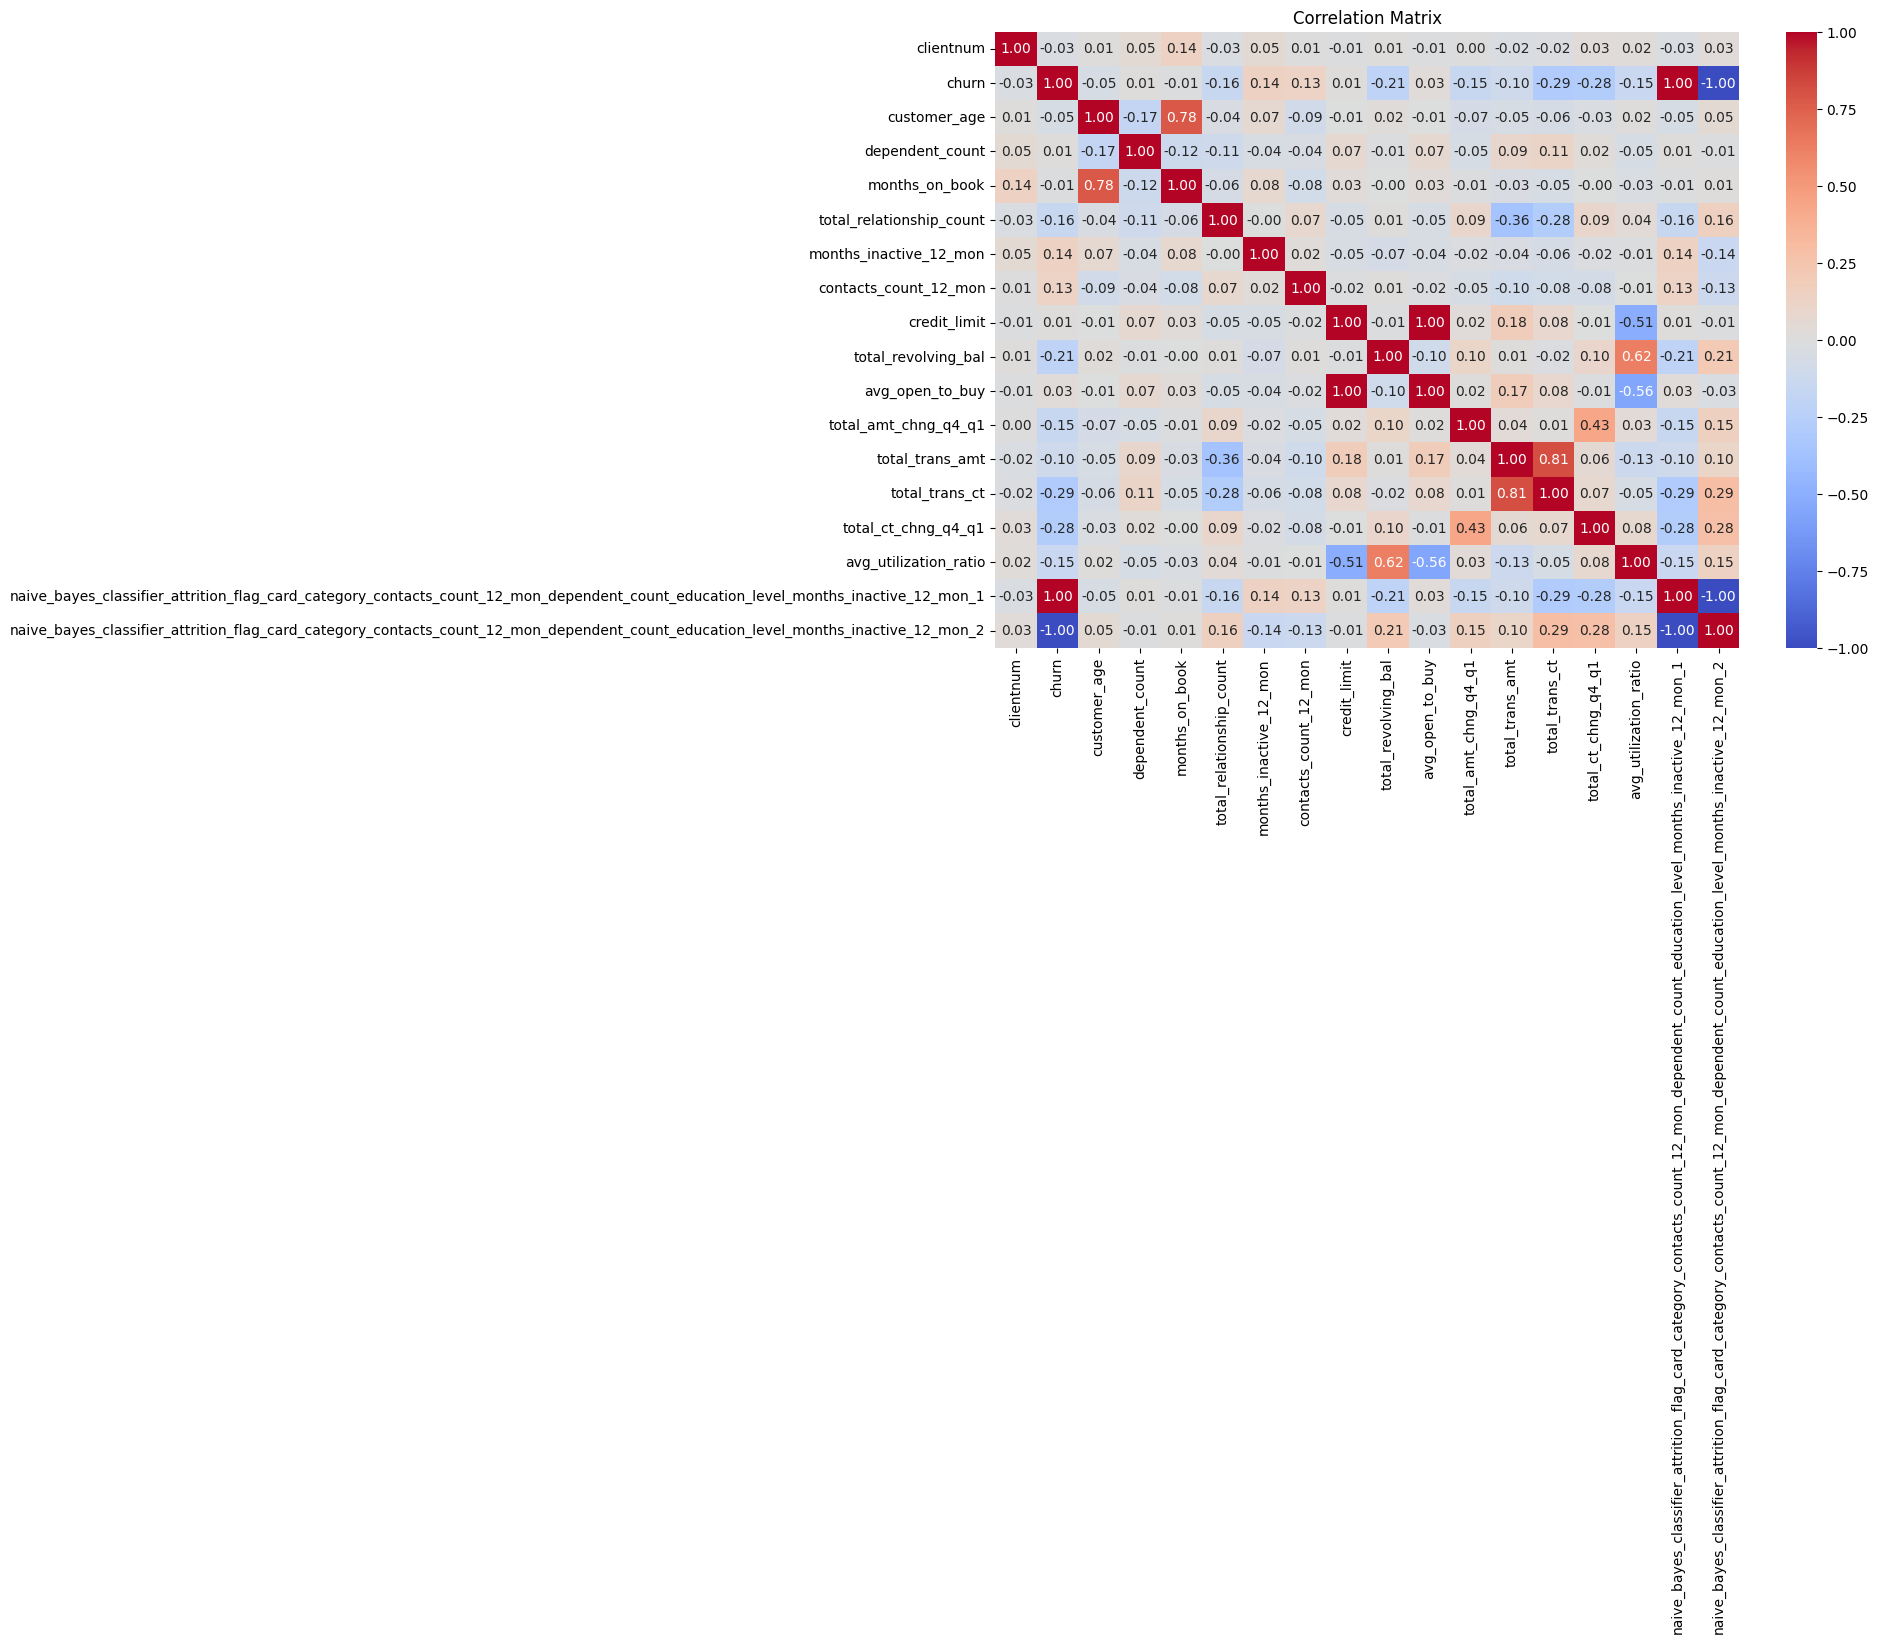

In [26]:

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


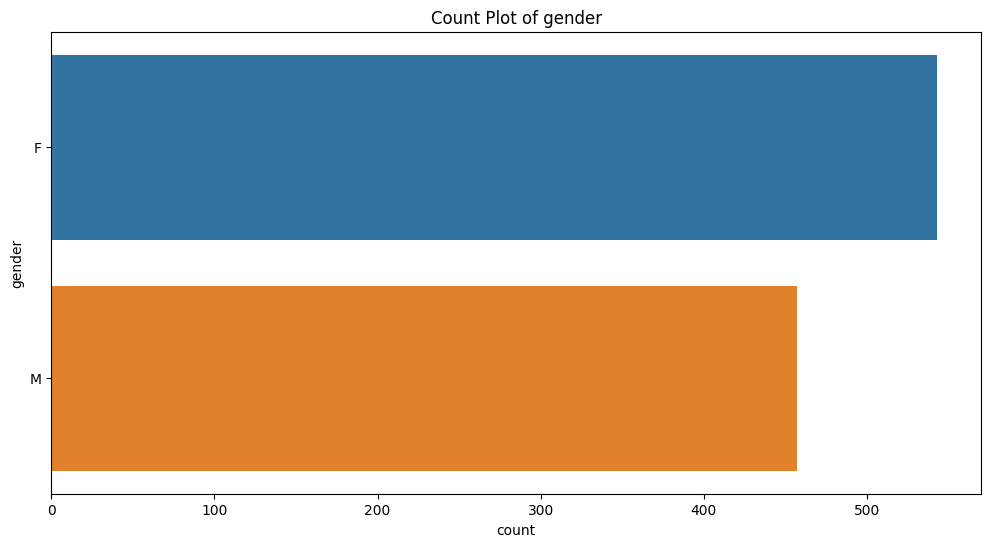

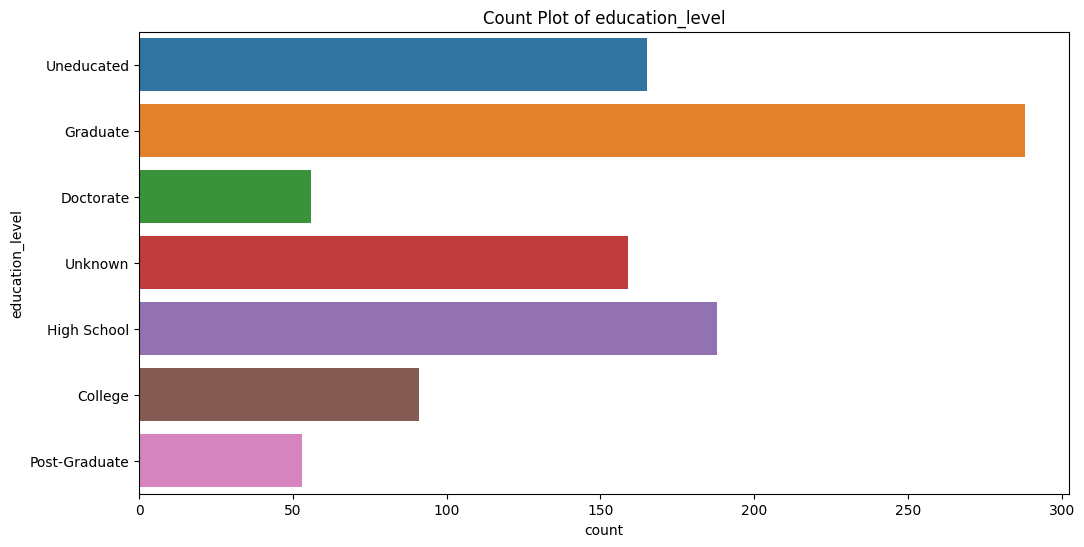

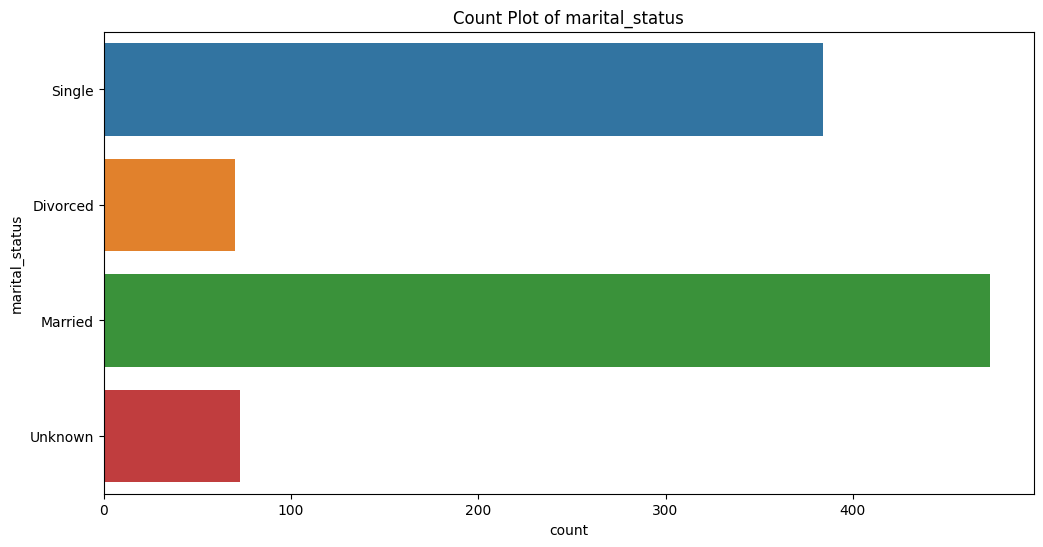

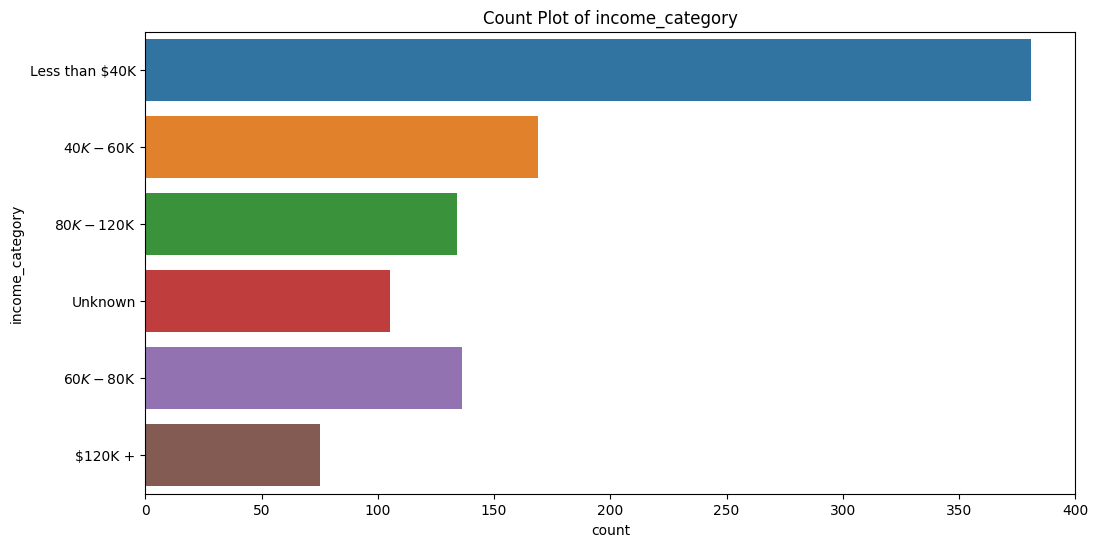

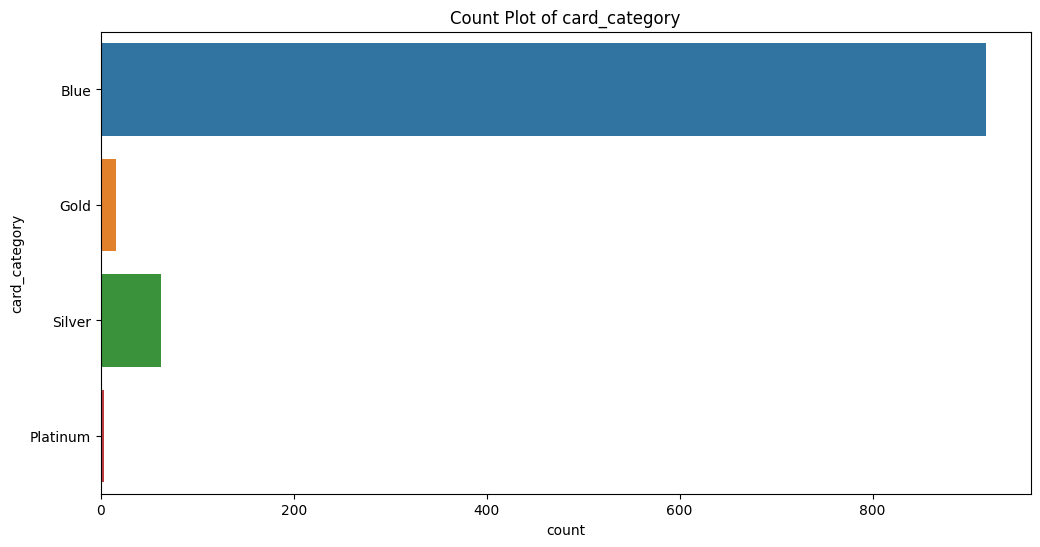

In [12]:

# Count plots for categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns
for feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(y=df[feature])
    plt.title(f'Count Plot of {feature}')
    plt.show()


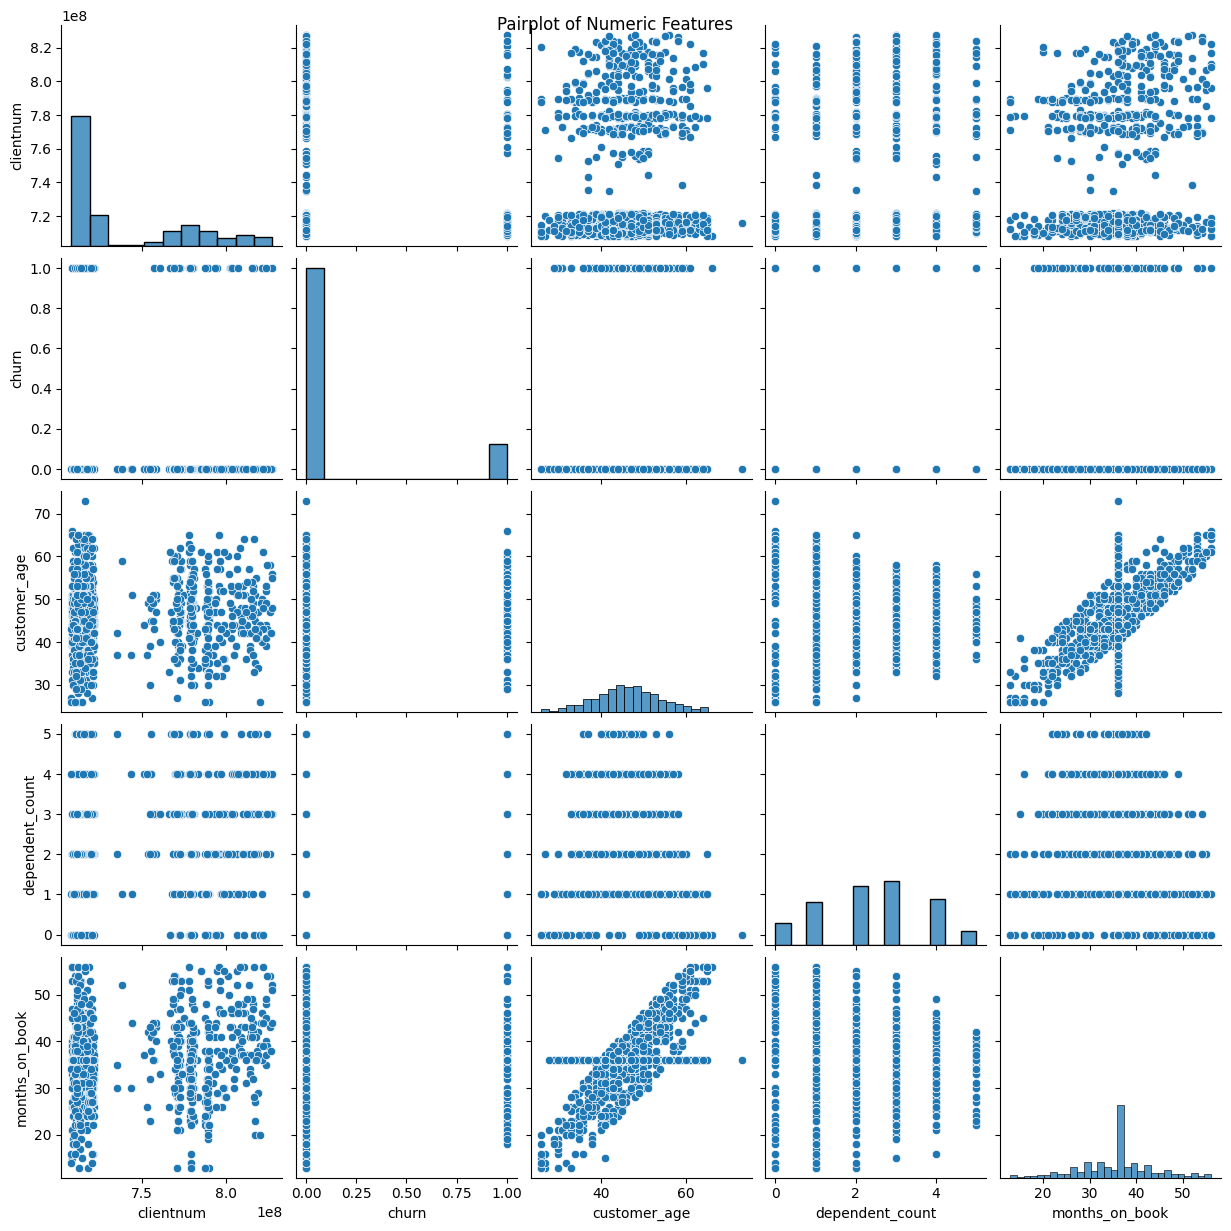

In [13]:

# Pairplot for a subset of numeric features
subset_numeric_features = numeric_features[:5]  # Select first 5 numeric features for pairplot
sns.pairplot(df[subset_numeric_features])
plt.suptitle('Pairplot of Numeric Features')
plt.show()


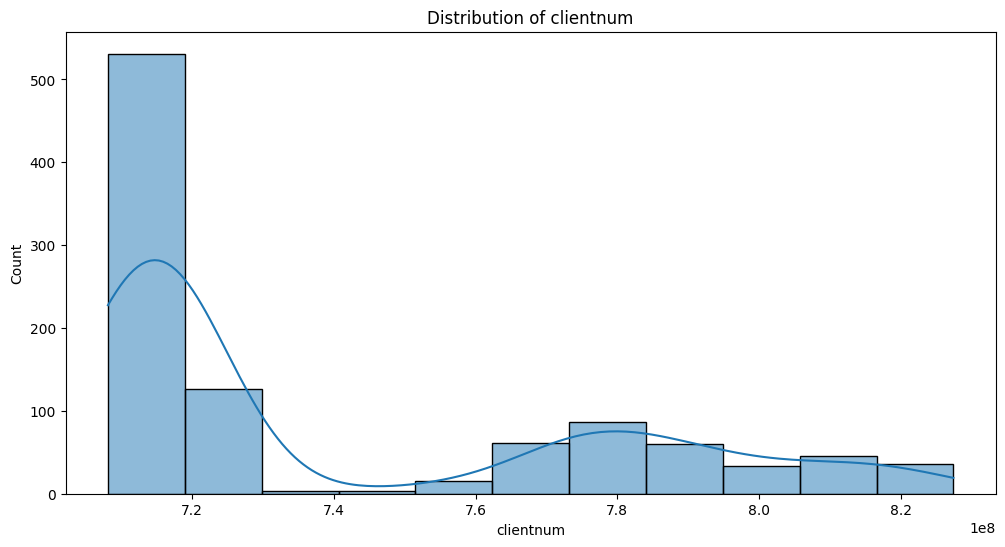

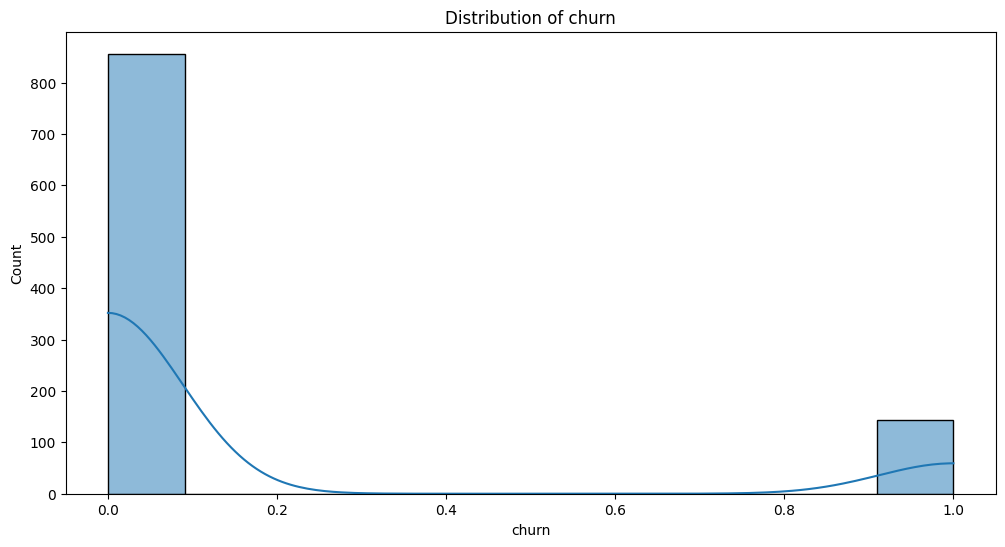

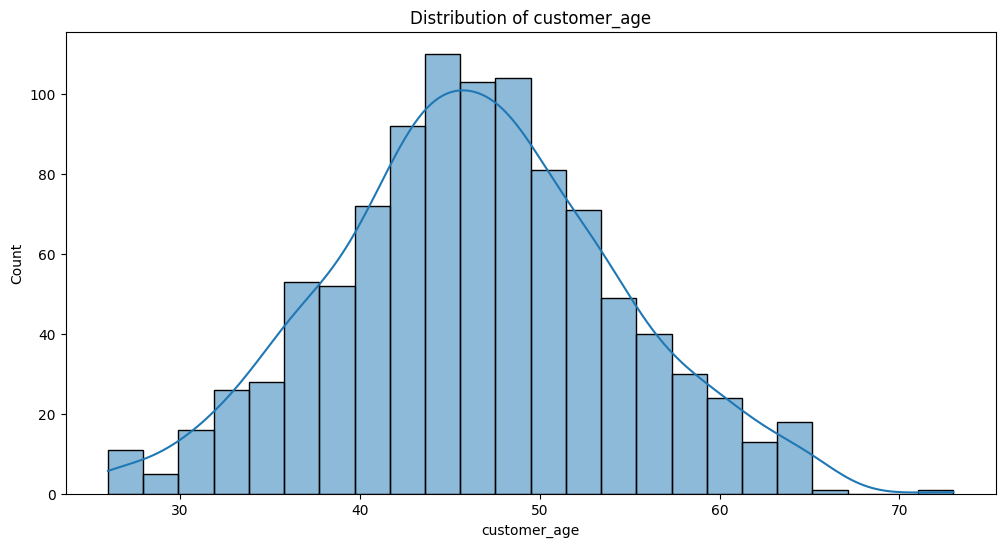

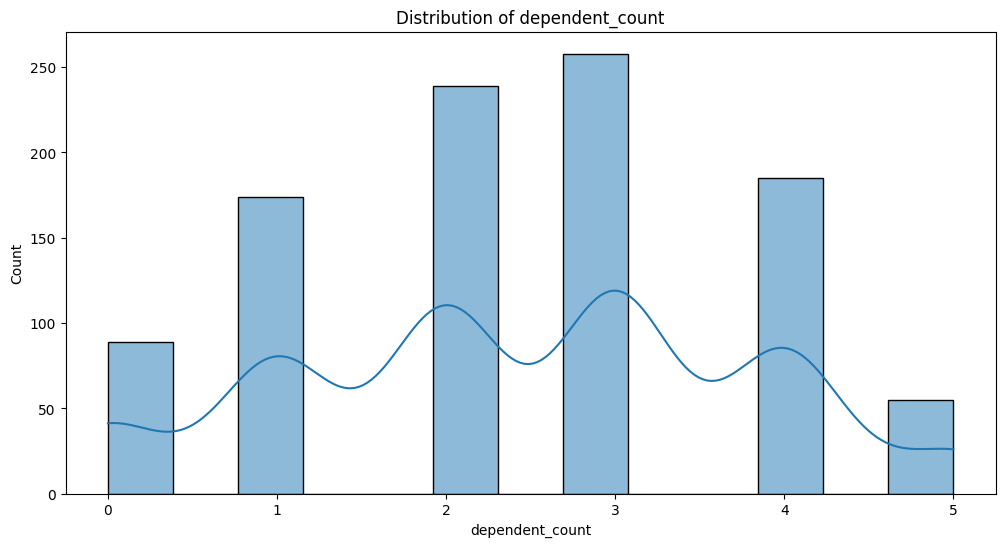

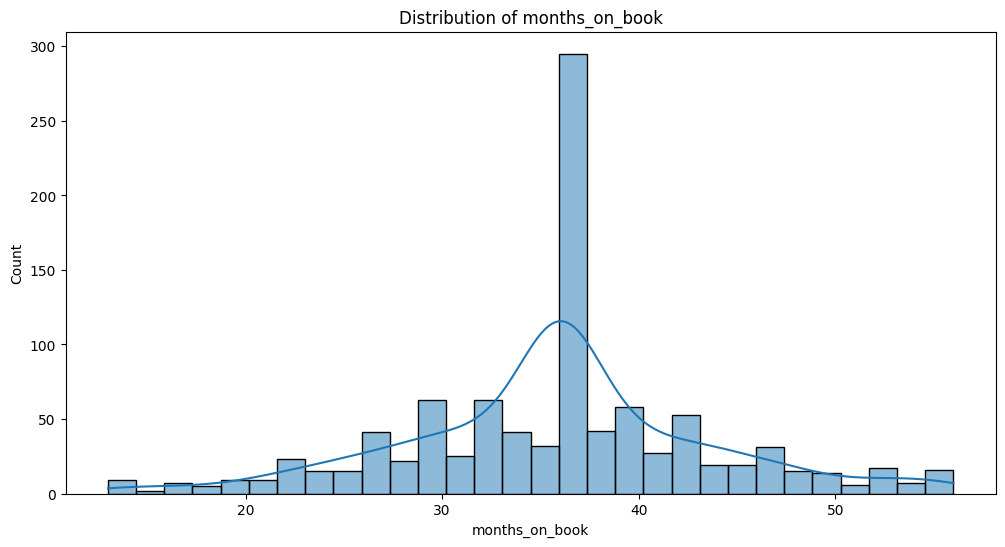

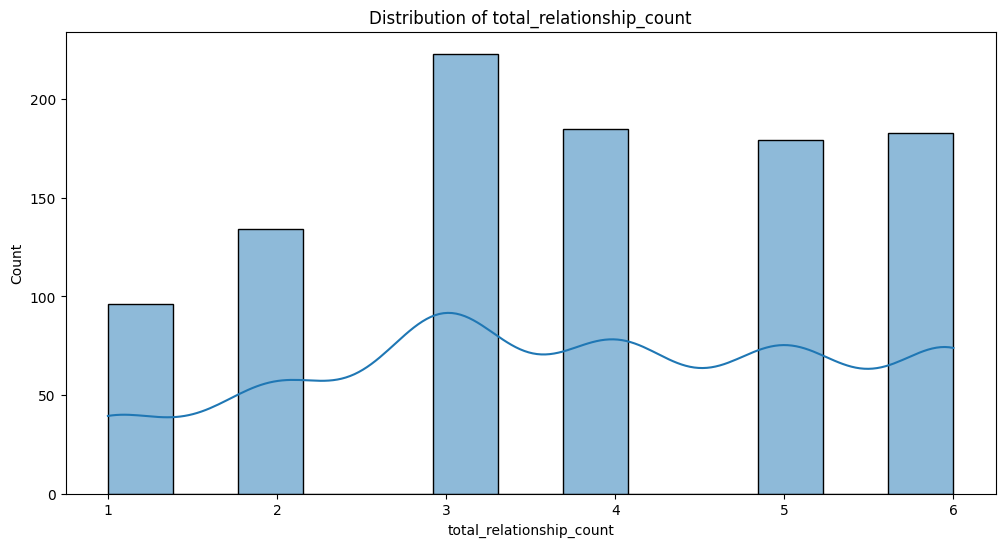

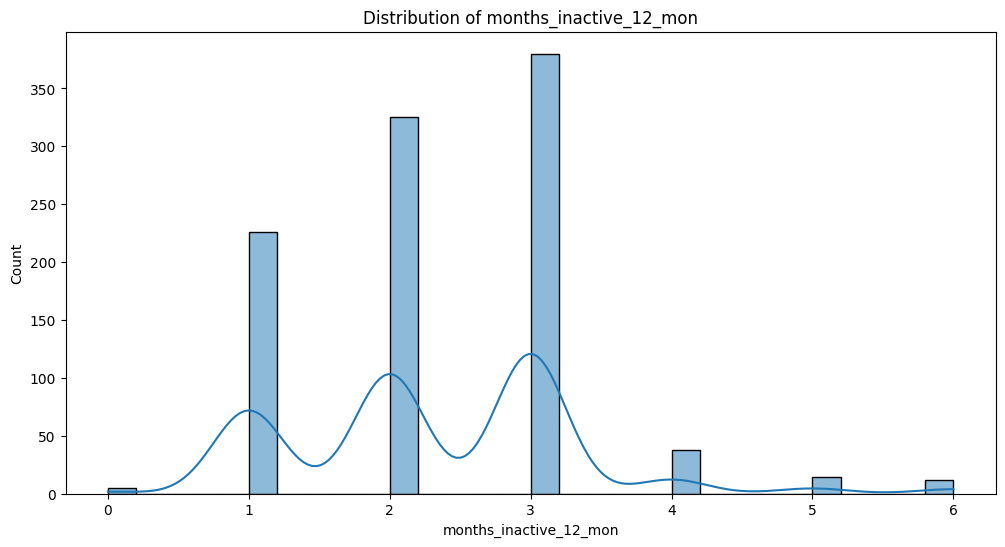

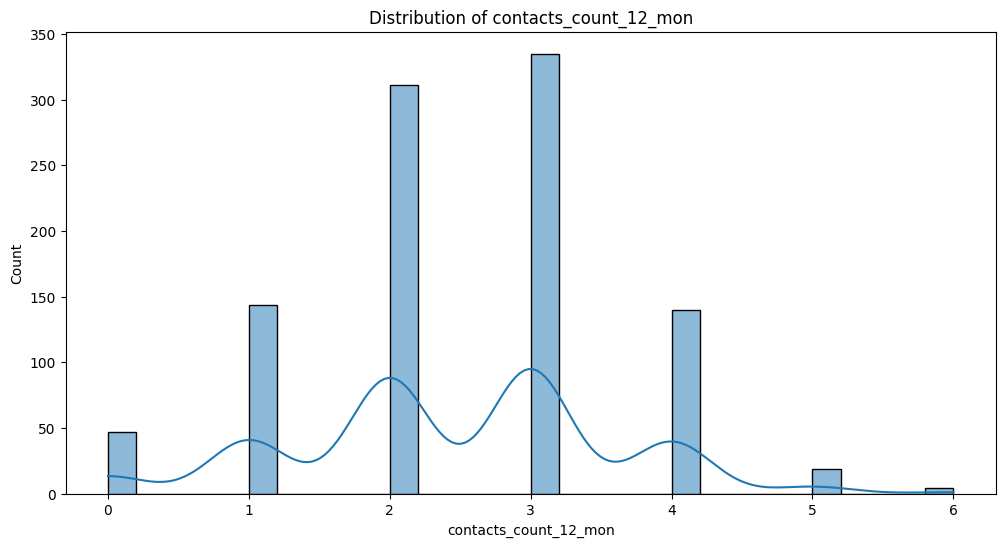

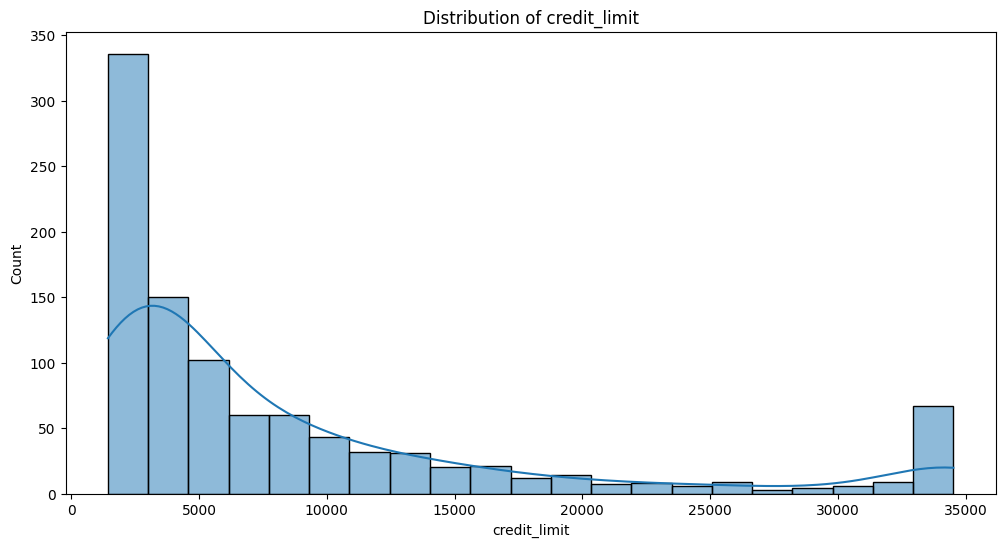

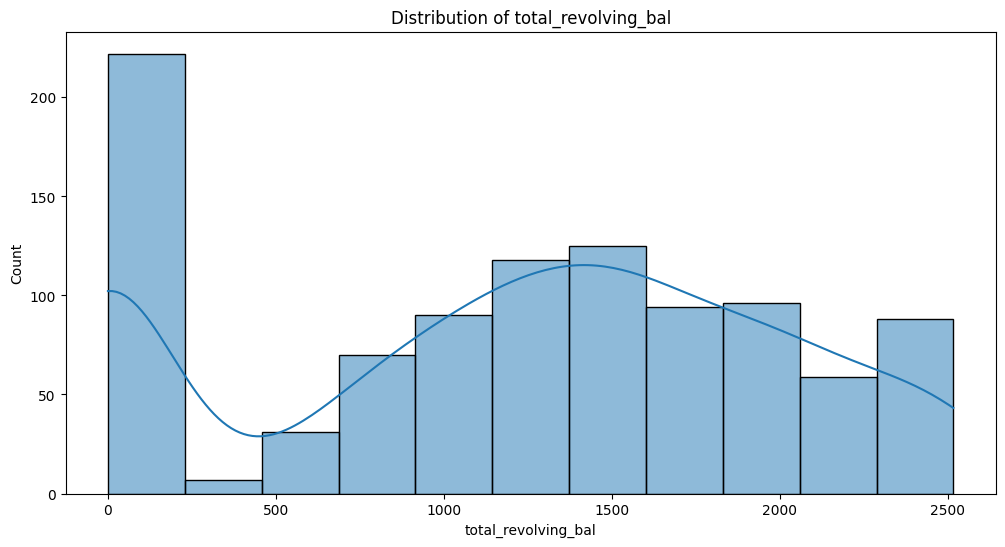

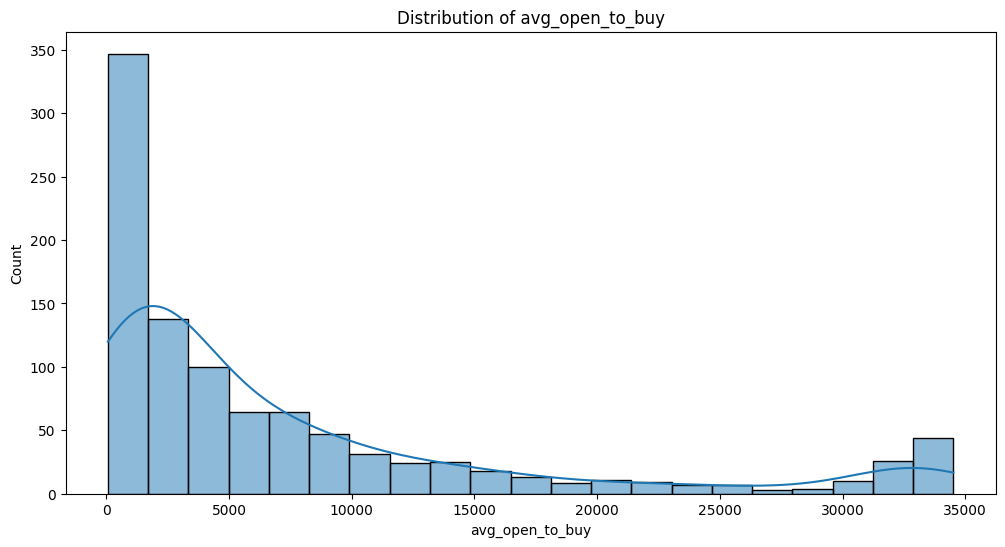

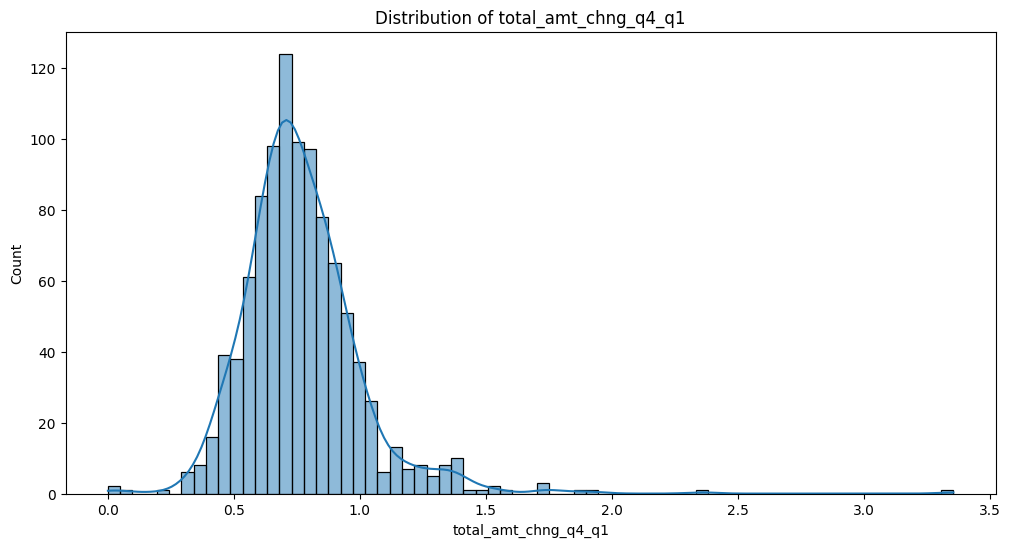

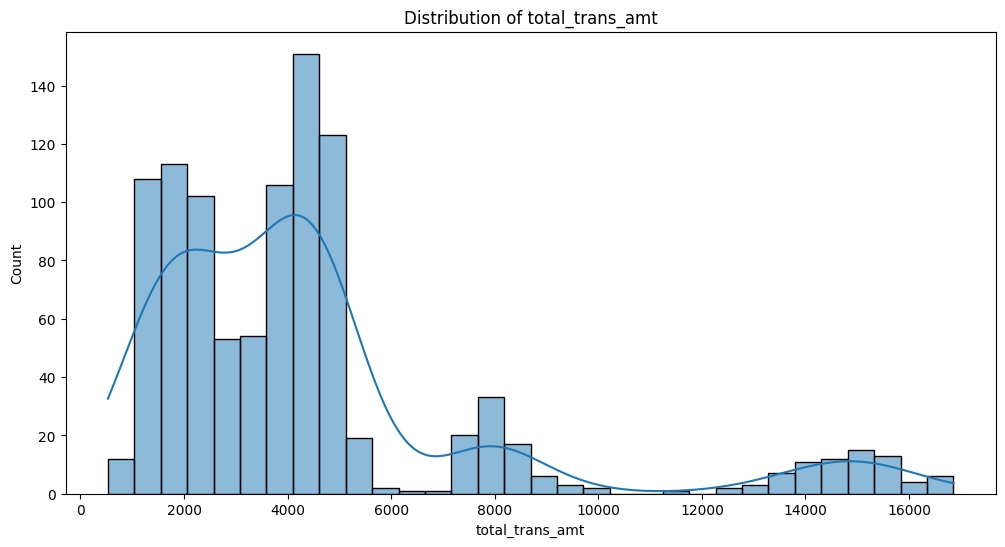

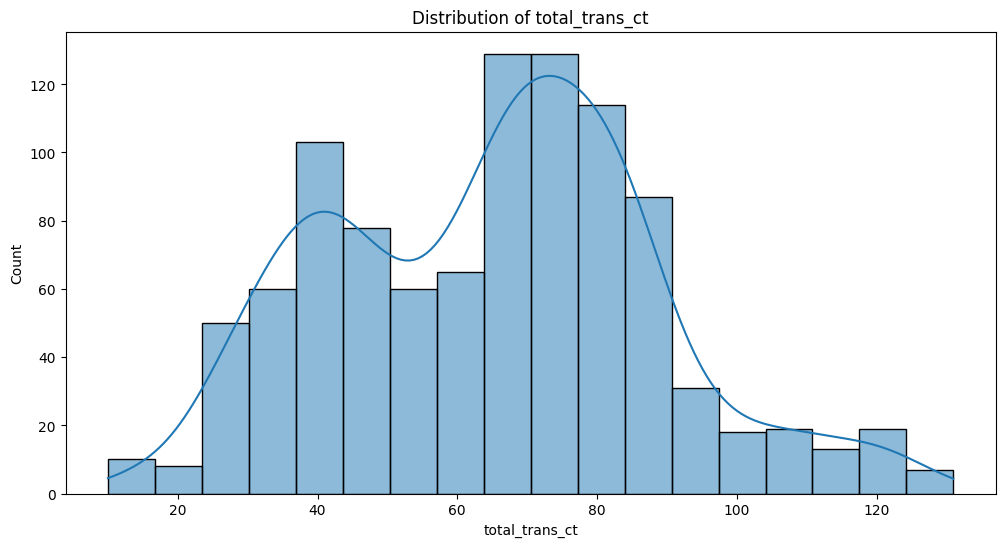

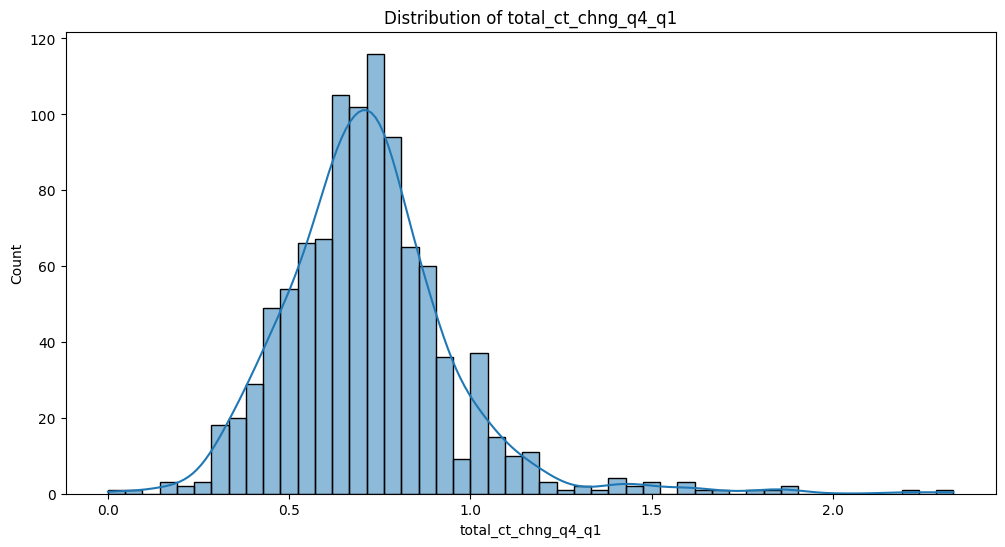

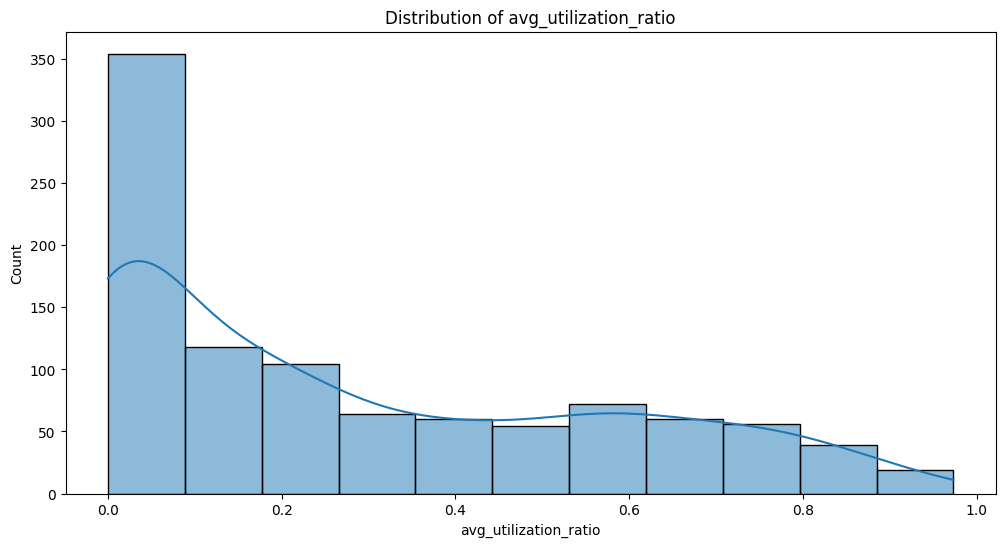

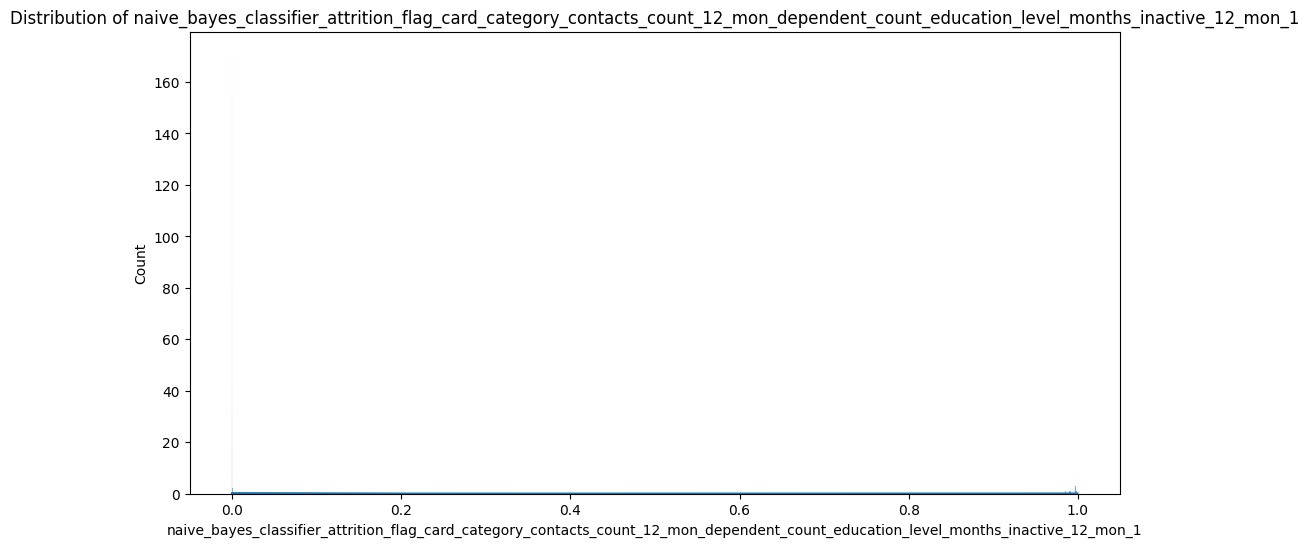

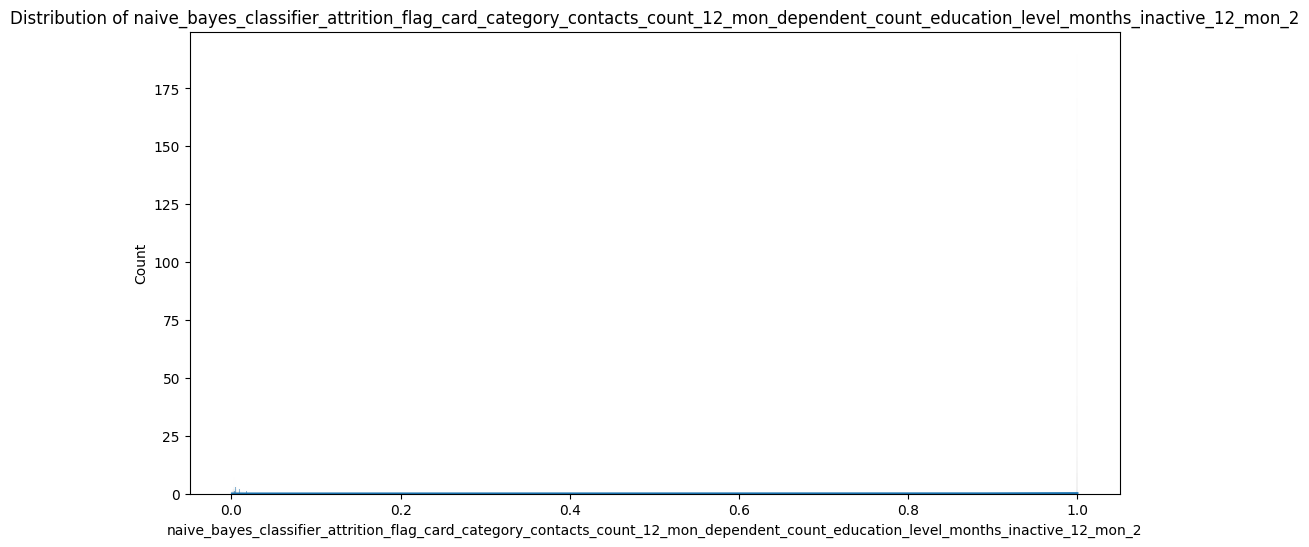

In [14]:

# Feature distributions
for feature in numeric_features:
    plt.figure(figsize=(12, 6))
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()


In [15]:

# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())



Number of duplicate rows:
0


# Testing for one model

##### No enough time for FastApi so test the model directly

In fast Api just load all the model, have user select dataset, and get input, pass the input to thar specific model and print output

In [31]:
import joblib
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the model
model_path = 'models/customertravel_model.pkl'
model = joblib.load(model_path)

# Sample data
data = {
    'age': [34, 34, 37, 30, 30, 27, 34, 34, 30, 36, 34, 28, 35],
    'frequentflyer': ['No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No Record'],
    'annualincomeclass': ['Middle Income', 'Low Income', 'Middle Income', 'Middle Income', 'Low Income', 'High Income', 'Middle Income', 'Low Income', 'Low Income', 'High Income', 'Low Income', 'Middle Income', 'Middle Income'],
    'servicesopted': [6, 5, 3, 2, 1, 1, 4, 2, 3, 1, 1, 2, 1],
    'accountsyncedtosocialmedia': ['No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'No', 'Yes', 'No', 'Yes'],
    'bookedhotelornot': ['Yes', 'No', 'No', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes'],
    'churn': [0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Define preprocessing steps (ensure these match what was used during training)
numeric_features = ['age', 'servicesopted']
categorical_features = ['frequentflyer', 'annualincomeclass', 'accountsyncedtosocialmedia', 'bookedhotelornot']

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numeric features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(df.drop('churn', axis=1))

# Make predictions
predictions = model.predict(X_preprocessed)

# Display the results
df['predicted_churn'] = predictions
df[['age', 'frequentflyer', 'annualincomeclass', 'servicesopted', 'accountsyncedtosocialmedia', 'bookedhotelornot', 'predicted_churn']]


,age,frequentflyer,annualincomeclass,servicesopted,accountsyncedtosocialmedia,bookedhotelornot,predicted_churn
0,34,No,Middle Income,6,No,Yes,0
1,34,Yes,Low Income,5,Yes,No,1
2,37,No,Middle Income,3,Yes,No,0
3,30,No,Middle Income,2,No,No,0
4,30,No,Low Income,1,No,No,0
5,27,Yes,High Income,1,No,Yes,1
6,34,No,Middle Income,4,Yes,Yes,0
7,34,No,Low Income,2,Yes,No,1
8,30,No,Low Income,3,No,Yes,0
9,36,Yes,High Income,1,No,No,1
